In [1]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt 

%matplotlib inline

In [4]:
X,y = make_regression(
        n_samples=100, n_features=10, n_informative=8, n_targets=3
    )

/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/matplotlib/collections.py:886: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


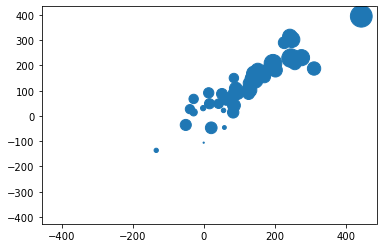

In [6]:
plt.scatter(y[:,0], y[:,1], y[:, 2])

In [2]:
def binh_korn(x, y): 
    f1 = 4*x**2 + 4 * y**2
    f2 = (x-5)**2 + (y-5)**2
    return -f1, -f2

In [3]:
import numpy as np
x = np.linspace(0,5,100)
y = np.linspace(0,3,100)

In [4]:
a = np.array([binh_korn(xi, yi) for xi, yi in zip(x, y)])

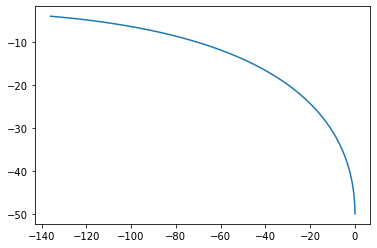

In [5]:
plt.plot(a[:,0], a[:,1])

In [6]:
from dispersant_screener.gp import build_model, build_coregionalized_model, predict_coregionalized

In [7]:
x = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])

In [23]:
indices= [1,2, 10, 20, 50, 60, 70, 80, -1]

In [24]:
model = build_coregionalized_model(x[np.array(indices)], a[np.array(indices)])

In [25]:
model.optimize_restarts()

Optimization restart 1/10, f = -24.527959323436214
Optimization restart 2/10, f = -24.479418508912847
Optimization restart 3/10, f = -24.197881827352695
Optimization restart 4/10, f = -24.46511499931686
Optimization restart 5/10, f = -24.38344302310327
Optimization restart 6/10, f = -24.55475677171716
Optimization restart 7/10, f = -24.43397282226036
Optimization restart 8/10, f = -24.49423116616248
Optimization restart 9/10, f = -24.442644696662274
Optimization restart 10/10, f = -24.482947641612974


In [26]:
y0 = predict_coregionalized(model, x, 0)
y1 = predict_coregionalized(model, x, 1)

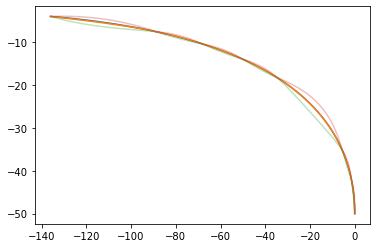

In [27]:
plt.plot(a[:,0], a[:,1])
plt.plot(y0[0], y1[0])

plt.plot(y0[0]-y0[1], y1[0]-y0[1], alpha=.3)
plt.plot(y0[0]+y0[1], y1[0]+y0[1], alpha=.3)

In [60]:
for i in range(100):
    print(dominance_check_jitted_2(lows * (1 + np.array([0.1, 0.1])), highs[i]))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [28]:
from dispersant_screener.pal import _pareto_classify

In [114]:
from typing import Tuple
from dispersant_screener.utils import dominance_check_jitted_3, is_pareto_efficient, dominance_check_jitted_2


def _pareto_classify(  # pylint:disable=too-many-arguments, too-many-locals
    pareto_optimal_0: np.array,
    not_pareto_optimal_0: np.array,
    unclassified_0: np.array,
    rectangle_lows: np.array,
    rectangle_ups: np.array,
    epsilon: np.array,
) -> Tuple[np.array, np.array, np.array]:
    """Performs the classification part of the algorithm
    (p. 4 of the PAL paper, see algorithm 1/2 of the epsilon-PAL paper)

    One core concept is that once a point is classified,
    it does no longer change the class.

    When we do the comparison with +/- epsilon we always use the absolute values!
    Otherwise, we get inconcistent results depending on the sign! 

    Args:
        pareto_optimal_0 (np.array): boolean mask of points classified as Pareto optimal
        not_pareto_optimal_0 (np.array): boolean mask of points
            classified as non-Pareto optimal
        unclassified_0 (np.array): boolean mask of unclassified points
        rectangle_lows (np.array): lower uncertainity boundaries
        rectangle_ups (np.array): upper uncertainity boundaries
        epsilon (np.array): granularity parameter (one per dimension)

    Returns:
        Tuple[list, list, list]: binary encoded list of Pareto optimal,
            non-Pareto optimal and unclassified points
    """
    pareto_optimal_t = pareto_optimal_0.copy()
    not_pareto_optimal_t = not_pareto_optimal_0.copy()
    unclassified_t = unclassified_0.copy()

    # This part is only relevant when we have points in set P
    # Then we can use those points to discard points from p_pess (P \cup U)
    if sum(pareto_optimal_0) > 0:
        pareto_indices = np.where(pareto_optimal_0 == 1)[0]
        pareto_pessimistic_lows = rectangle_lows[pareto_indices]  # p_pess(P)
        for i in range(0, len(unclassified_0)):
            if unclassified_t[i] == 1:
                if dominance_check_jitted_2(
                    pareto_pessimistic_lows + epsilon * np.abs(pareto_pessimistic_lows),
                    rectangle_ups[i],
                ):
                    not_pareto_optimal_t[i] = 1
                    unclassified_t[i] = 0

    pareto_unclassified_indices = np.where(pareto_optimal_0 | unclassified_t)[0]

    pareto_unclassified_lows = rectangle_lows[pareto_unclassified_indices]

    # assuming maximization
    pareto_unclassified_pessimistic_mask = is_pareto_efficient(
        -pareto_unclassified_lows
    )
    original_indices = pareto_unclassified_indices[pareto_unclassified_pessimistic_mask]
    pareto_unclassified_pessimistic_points = pareto_unclassified_lows[
        pareto_unclassified_pessimistic_mask
    ]

    for i in range(0, len(unclassified_t)):  # pylint:disable=consider-using-enumerate
        # We can only discard points that are unclassified so far
        # We cannot discard points that are part of p_pess(P \cup U)
        if (unclassified_t[i] == 1) and (i not in original_indices):
            # If the upper bound of the hyperrectangle is not dominating anywhere
            # the pareto pessimitic set, we can discard
            if dominance_check_jitted_2(
                pareto_unclassified_pessimistic_points
                + epsilon * np.abs(pareto_unclassified_pessimistic_points),
                rectangle_ups[i],
            ):
                not_pareto_optimal_t[i] = 1
                unclassified_t[i] = 0

    # now, update the pareto set
    # if there is no other point x' such that max(Rt(x')) >= min(Rt(x))
    # move x to Pareto
    unclassified_indices = np.where(unclassified_t | pareto_optimal_t)[0]
    unclassified_ups = np.array(rectangle_ups[unclassified_indices])

    index_map = {index: i for i, index in enumerate(unclassified_indices)}

    # The index map helps us to mask the current point from the unclassified_ups list
    for i in range(0, len(unclassified_t)):  # pylint:disable=consider-using-enumerate
        # again, we only care about unclassified points
        if unclassified_t[i] == 1:
            # If there is no other point which up is epsilon dominating
            # the low of the current point,
            # the current point is epsilon-accurate Pareto optimal
            if not dominance_check_jitted_3(
                unclassified_ups,
                rectangle_lows[i] + epsilon * np.abs(rectangle_lows[i]),
                index_map[i],
            ):
                pareto_optimal_t[i] = 1
                unclassified_t[i] = 0

    return pareto_optimal_t, not_pareto_optimal_t, unclassified_t

In [111]:
pareto_optimal = np.array([False] * len(y))
discarded = np.array([False] * len(y))
unclassified = np.array([True] * len(y))
lows = np.hstack([y0[0]-y0[1], y1[0]-y0[1]])
highs = np.hstack([y0[0]+y0[1], y1[0]+y0[1]])

In [118]:
_pareto_classify(pareto_optimal, discarded, unclassified, a, a, epsilon=np.array([0.1, 0.1]))

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, Fal

In [109]:
from numpy import abs, cos, exp, mean, pi, prod, sin, sqrt, sum, divide
import numpy 

class Branin(object):
    def __init__(self):
        self._dim = 2
        self._search_domain = numpy.array([[0.0, 15.0], [-5.0, 15.0]])
        self._num_init_pts = 3
        self._sample_var = 0.0
        self._min_value = 0.397887
        self._observations = []#numpy.arange(self._dim)
        self._num_fidelity = 0

    def evaluate_true(self, x):
        """ This function is usually evaluated on the square x_1 \in [0, 15], x_2 \in [-5, 15]. Global minimum
        is at x = [pi, 2.275] and [9.42478, 2.475] with minima f(x*) = 0.397887.
            :param x[2]: 2-dim numpy array
        """
        a = 1
        b = 5.1 / 4 * pow(numpy.pi, 2.0)
        c = 5 / numpy.pi
        r = 6
        s = 10
        t = 1 / 8 * numpy.pi
        return numpy.array([(a * pow(x[1] - b * pow(x[0], 2.0) + c * x[0] - r, 2.0) + s * (1 - t) * numpy.cos(x[0]) + s),
                (2*a*(x[1] - b * pow(x[0], 2.0) + c * x[0] - r) * (-2* b * x[0] + c) + s * (1 - t) * (-numpy.sin(x[0]))),
                (2*a*(x[1] - b * pow(x[0], 2.0) + c * x[0] - r))])

    def evaluate(self, x):
        return self.evaluate_true(x)

In [34]:
branin = Branin()

In [216]:
x = [-2, 0, 0.25, 0.5, 2]

In [217]:
y = [0, -0.5, -2.5, -1.5,-0.1]

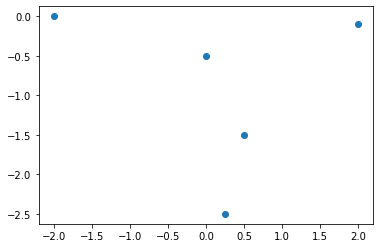

In [218]:
plt.scatter(x, y)

In [249]:
from scipy.stats import norm
def expected_improvement(mu, sigma, mu_sample, xi=0.01):
    '''
    https://krasserm.github.io/2018/03/21/bayesian-optimization/
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Returns:
        Expected improvements at points X.
    '''
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.min(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu_sample_opt - mu 
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [285]:
ei = expected_improvement(mu, np.sqrt(std), y)

In [219]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

In [220]:
model = build_model(np.array(x).reshape(-1,1), np.array(y).reshape(-1,1), 
                    kernel=GPy.kern.Matern52(1, variance=1))

In [221]:
model.optimize_restarts(10)

Optimization restart 1/10, f = 7.083925248658526
Optimization restart 2/10, f = 7.0839252920467635
Optimization restart 3/10, f = 7.083925237212034
Optimization restart 4/10, f = 7.083925243207711
Optimization restart 5/10, f = 7.083925239650806
Optimization restart 6/10, f = 7.0839252369258965
Optimization restart 7/10, f = 7.083925253384996
Optimization restart 8/10, f = 7.094692666023346
Optimization restart 9/10, f = 7.083925238594883
Optimization restart 10/10, f = 7.0839252437603335


In [283]:
mu, std = model.predict(np.linspace(-2,2,400).reshape(-1,1))

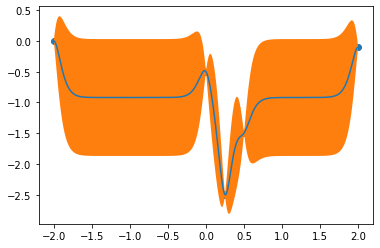

In [280]:
plt.scatter(x, y)
plt.plot(np.linspace(-2,2,400), mu.flatten())
plt.fill_between(np.linspace(-2,2,400), mu.flatten() - np.sqrt(std.flatten()), mu.flatten()+ np.sqrt(std.flatten()))
#plt.plot(np.linspace(-2,0.5,100), samples.reshape(100,10)[:,0])

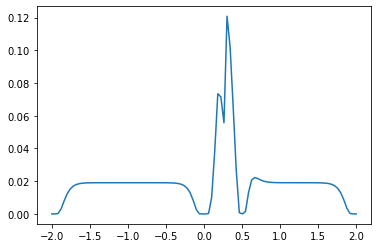

In [252]:
plt.plot(np.linspace(-2,2,100), ei.flatten())

In [281]:
np.linspace(-2,2,400)[np.argmax(ei)]

-1.4285714285714286

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


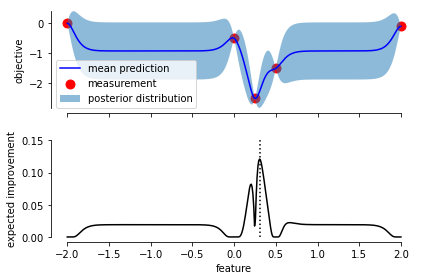

In [286]:
plt.rcParams['font.family'] = 'sans-serif'
fig, ax = plt.subplots(2, 1, sharex=True)

for a in ax: 
    a.spines['top'].set_color('none')
    a.spines['right'].set_color('none')
    a.spines['left'].set_smart_bounds(True)
    a.spines['bottom'].set_smart_bounds(True)
    
    
    
ax[0].scatter(x, y, c='r', s =80, label='measurement')
ax[0].plot(np.linspace(-2,2,400), mu.flatten(), c='blue', label='mean prediction')
ax[0].fill_between(np.linspace(-2,2,400), mu.flatten() - np.sqrt(std.flatten()),
                   mu.flatten()+ np.sqrt(std.flatten()), alpha=.5,label='posterior distribution')


ax[1].plot(np.linspace(-2,2,400), ei.flatten(), c='k')
ax[1].vlines(np.linspace(-2,2,400)[np.argmax(ei)], 0, 0.15, ls='dotted')

ax[1].set_ylabel('expected improvement')
ax[0].set_ylabel('objective')

ax[1].set_xlabel('feature')

ax[0].legend()

fig.tight_layout()
fig.savefig('ei_1d_example.pdf', bbox_inches='tight')